# Context 

Using weights and biases to performe hyper parameter optimization

In [2]:
import os
import re
import shutil
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models,transforms,datasets
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.model_selection import KFold
import itertools
import wandb

/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_10342/3334222264.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Use available device

In [3]:
device = "cpu"
if torch.cuda.is_available():
    print("using gpu")
    device = torch.device("gpu")
elif torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")

using mps


## Data loader

In [4]:
resized_images = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [5]:
data_dir = '../Data/brain_tumor/brain_tumor_dataset/'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=resized_images) for x in ['train', 'test']}

In [6]:
train_loader = torch.utils.data.DataLoader(dsets['train'], batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=8, shuffle=False, num_workers=2)

## Train/test functions

In [7]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1,verbose=True):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        if verbose:
            print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [8]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        bs = labels.size(0)

        output = model.forward(inputs)
        loss = loss_fn(output, labels)

        pred = output.max(1, keepdim=True)[1]
        running_loss += loss
        running_corrects += pred.eq(labels.view_as(pred)).sum()

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [9]:
def train_and_test(model,data_loader_train, data_loader_test,loss_fn,optimizer,n_epochs=1):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    loss_test = np.zeros(n_epochs)
    acc_test = np.zeros(n_epochs)
    
    for epoch_num in tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_train:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_test:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)

            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()

            size += bs

        print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))
        loss_test[epoch_num] = running_loss / size
        acc_test[epoch_num] = running_corrects.item() / size
        
    return loss_train, acc_train, loss_test, acc_test

In [10]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    labels_all = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    
    return labels_all, predictions

In [11]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (4, 4))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [12]:
def evaluation_plots(model, test_loader, loss_train, acc_train, loss_test, acc_test):
    plt.plot(np.arange(1,len(loss_train)+1), loss_train, label='Loss train')
    plt.plot(np.arange(1,len(loss_test)+1), loss_test, label='Loss test')
    plt.legend()
    plt.title('Loss according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(np.arange(1,len(loss_train)+1), np.log(loss_train), label='Loss train')
    plt.plot(np.arange(1,len(loss_test)+1), np.log(loss_test), label='Loss test')
    plt.legend()
    plt.title('Log loss according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.show()
    
    plt.plot(np.arange(1,len(acc_train)+1), acc_train, label='Train accuracy')
    plt.plot(np.arange(1,len(acc_test)+1), acc_test, label='Test accuracy')
    plt.legend()
    plt.title('Accuracy according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    labels, predictions = predict(model,test_loader)

    target_names = ['yes','no']

    cm = confusion_matrix(labels, predictions)
    plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

    print(classification_report(labels, predictions, target_names= target_names))

## Models framework

We'll explore different neural network shape: large, deep, and pyramidal

### Large neural network

Only one layer with a large number of convolutional kernels

In [13]:
class classifier_large(nn.Module):

    def __init__(self, dropout_rate):
        super(classifier_large, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_features=50*75*75, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2, padding=0)
        x = self.dropout1(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        
        return x

### Deep neural network

3 layers, a low number of convolutional kernels, each layer having about the same parameters

In [14]:
class classifier_deep(nn.Module):

    def __init__(self, dropout_rate):
        super(classifier_deep, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(in_features=100, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2, padding=0)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=3, padding=0)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=5, padding=0)
        x = self.dropout3(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

### Pyramidal neural network

Start with a large number of convolutional kernels on the first hidden layers, which decrease as we go deeper

In [15]:
class classifier_pyramid(nn.Module):

    def __init__(self, dropout_rate):
        
        super(classifier_pyramid, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv2d(in_channels=25, out_channels=5, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc = nn.Linear(in_features=125,
                            out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2, padding=0)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=3, padding=0)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=5, padding=0)
        x = self.dropout3(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        return x
    
    def predict(self, data_loader):
        self.eval()
        predictions = []
        labels_all = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())
        
        self.train() 
        return labels_all, predictions

#### Test 

In [16]:
# Initialize the model and optimizer

# conv_class = classifier_large(0.5)

# conv_class = classifier_deep(0.5)

conv_class = classifier_pyramid(0.5)

loss_fn = nn.NLLLoss()
learning_rate = 0.0001
optimizer_cl = torch.optim.RMSprop(conv_class.parameters())

# Train the model on the current fold
loss_train, acc_train = train(conv_class, train_loader, loss_fn, optimizer_cl, 2, verbose=True)

Train - Loss: 61.6046 Acc: 0.5536
Train - Loss: 5.1077 Acc: 0.4940


## Hyperparameter optimization with cross validation

In [17]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: oriane-cavrois. Use `wandb login --relogin` to force relogin


True

Weight and biases project: https://wandb.ai/oriane-cavrois/brain_image_architecture_optimization_3

In [18]:
# Define the number of folds and batch size
k_folds = 3

# Count the number of iterations
iterations = 50

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Hyperparameters distribution
epochs_distrib = [5,10,15,20,25,30,35,40]
lr_distrib = np.linspace(1e-4, 1e-2, 19)
batch_size_distrib = np.arange(3,12)
architecture_distrib = ['large','deep','pyramid']
dropout_rate_distrib = np.linspace(0, 1, 21)

params = {}
loss_train_dict = {}
acc_train_dict = {}
test_loss_dict = {}
test_acc_dict = {}

# Select randomly value from the distribution
for i in range(iterations):
    print('Iteration', i+1)
    epoch = random.choice(epochs_distrib)
    lr = random.choice(lr_distrib)
    batch_size = int(random.choice(batch_size_distrib))
    architecture = random.choice(architecture_distrib)
    dropout_rate = random.choice(dropout_rate_distrib)
    
    # Initialize the model and optimizer
    if architecture == 'large':
        conv_class = classifier_large(dropout_rate)
        
    elif architecture == 'deep':
        conv_class = classifier_deep(dropout_rate)
        
    elif architecture == 'pyramid':
        conv_class = classifier_pyramid(dropout_rate)
        
    params[i] = (epoch, lr, batch_size, architecture, dropout_rate)
    
    loss_fn = nn.NLLLoss()
    learning_rate = lr
    optimizer_cl = torch.optim.RMSprop(conv_class.parameters())
    
    loss_train_iter = []
    acc_train_iter = []
    test_loss_iter = []
    test_acc_iter = []
    print('Architecture:',architecture)
    print('Number of epochs:',epoch)
    print(params[i])
    
    run = wandb.init(
        # Set the project where this run will be logged
        project="brain_image_architecture_optimization_3",
        # Track hyperparameters and run metadata
        config={"epochs": epoch, "learning_rate": lr, "batch size": batch_size, "architecture": architecture, "drop out": dropout_rate}
    )
    with run:
        # Loop through each fold
        for fold, (train_idx, test_idx) in enumerate(kf.split(dsets['train'])):
            print(f"Fold {fold + 1}")
            print("-------")

            # Define the data loaders for the current fold
            train_loader_cv = torch.utils.data.DataLoader(
                dataset=dsets['train'],
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(train_idx),
            )
            test_loader_cv = torch.utils.data.DataLoader(
                dataset=dsets['train'],
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(test_idx),
            )

            # Train the model on the current fold
            loss_train, acc_train = train(conv_class, train_loader_cv, loss_fn, optimizer_cl, epoch, verbose=False)

            loss_train_iter.append(loss_train)
            acc_train_iter.append(acc_train)
            # Evaluate the model on the test set
            conv_class.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader_cv:
                    data, target = data.to(device), target.to(device)
                    output = conv_class(data)
                    test_loss += nn.functional.nll_loss(output, target, reduction="sum").item()
                    pred = output.max(1, keepdim=True)[1]
                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_loss_iter.append(test_loss)
            accuracy = 100.0 * correct / len(test_loader.dataset)
            test_acc_iter.append(correct / len(test_loader.dataset))

            # Print the results for the current fold
            print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
            
        loss_train_dict[i] = np.mean(loss_train_iter)
        acc_train_dict[i] = np.mean(acc_train_iter)
        test_loss_dict[i] = np.mean(test_loss_iter)
        test_acc_dict[i] = np.mean(test_acc_iter)
        
        wandb.log({"train accuracy": acc_train_dict[i], "train loss": loss_train_dict[i], "test accuracy": test_acc_dict[i], "test loss": test_loss_dict[i]})
        
        print("--------------------------------------")

Iteration 1
Architecture: large
Number of epochs: 5
(5, 0.0078000000000000005, 6, 'large', 0.35000000000000003)


Fold 1
-------
Test set: Average loss: 46.2876, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 2.1444, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 0.8259, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59608
test loss,16.41932
train accuracy,0.85298
train loss,102.77076


Iteration 2
Architecture: deep
Number of epochs: 20
(20, 0.00285, 11, 'deep', 0.45)


Fold 1
-------
Test set: Average loss: 0.8544, Accuracy: 22/85 (25.88%)

Fold 2
-------
Test set: Average loss: 0.3889, Accuracy: 44/85 (51.76%)

Fold 3
-------
Test set: Average loss: 0.4325, Accuracy: 36/85 (42.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.4
test loss,0.55859
train accuracy,0.62932
train loss,0.29885


Iteration 3
Architecture: deep
Number of epochs: 5
(5, 0.006150000000000001, 9, 'deep', 0.0)


Fold 1
-------
Test set: Average loss: 0.5495, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 0.2995, Accuracy: 45/85 (52.94%)

Fold 3
-------
Test set: Average loss: 0.3928, Accuracy: 38/85 (44.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.49412
test loss,0.41394
train accuracy,0.67262
train loss,1.02606


Iteration 4
Architecture: deep
Number of epochs: 40
(40, 0.00285, 4, 'deep', 0.8)


Fold 1
-------
Test set: Average loss: 1.4894, Accuracy: 34/85 (40.00%)

Fold 2
-------
Test set: Average loss: 1.0607, Accuracy: 38/85 (44.71%)

Fold 3
-------
Test set: Average loss: 3.1733, Accuracy: 30/85 (35.29%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.4
test loss,1.90778
train accuracy,0.5494
train loss,0.59462


Iteration 5
Architecture: large
Number of epochs: 35
(35, 0.00835, 9, 'large', 0.2)


Fold 1
-------
Test set: Average loss: 36.2183, Accuracy: 50/85 (58.82%)

Fold 2
-------
Test set: Average loss: 270.3715, Accuracy: 47/85 (55.29%)

Fold 3
-------
Test set: Average loss: 17.9518, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59216
test loss,108.18052
train accuracy,0.94762
train loss,30.39501


Iteration 6
Architecture: deep
Number of epochs: 15
(15, 0.00395, 7, 'deep', 0.9500000000000001)


Fold 1
-------
Test set: Average loss: 3.9665, Accuracy: 33/85 (38.82%)

Fold 2
-------
Test set: Average loss: 0.9088, Accuracy: 34/85 (40.00%)

Fold 3
-------
Test set: Average loss: 1.1163, Accuracy: 36/85 (42.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.40392
test loss,1.99724
train accuracy,0.5248
train loss,2.15504


Iteration 7
Architecture: pyramid
Number of epochs: 40
(40, 0.0067, 11, 'pyramid', 0.75)


Fold 1
-------
Test set: Average loss: 11.6322, Accuracy: 17/85 (20.00%)

Fold 2
-------
Test set: Average loss: 98.6303, Accuracy: 22/85 (25.88%)

Fold 3
-------
Test set: Average loss: 26.4584, Accuracy: 30/85 (35.29%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.27059
test loss,45.57362
train accuracy,0.55975
train loss,2.39394


Iteration 8
Architecture: pyramid
Number of epochs: 15
(15, 0.01, 9, 'pyramid', 0.25)


Fold 1
-------
Test set: Average loss: 0.9918, Accuracy: 41/85 (48.24%)

Fold 2
-------
Test set: Average loss: 0.3972, Accuracy: 38/85 (44.71%)

Fold 3
-------
Test set: Average loss: 0.2911, Accuracy: 49/85 (57.65%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.50196
test loss,0.56006
train accuracy,0.65357
train loss,5.5065


Iteration 9
Architecture: deep
Number of epochs: 10
(10, 0.00395, 10, 'deep', 0.35000000000000003)


Fold 1
-------
Test set: Average loss: 0.4986, Accuracy: 34/85 (40.00%)

Fold 2
-------
Test set: Average loss: 0.3779, Accuracy: 42/85 (49.41%)

Fold 3
-------
Test set: Average loss: 0.3899, Accuracy: 37/85 (43.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.44314
test loss,0.42213
train accuracy,0.66964
train loss,0.37266


Iteration 10
Architecture: pyramid
Number of epochs: 25
(25, 0.0067, 10, 'pyramid', 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 43.6588, Accuracy: 37/85 (43.53%)

Fold 2
-------
Test set: Average loss: 73.1581, Accuracy: 35/85 (41.18%)

Fold 3
-------
Test set: Average loss: 91.9210, Accuracy: 32/85 (37.65%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.40784
test loss,69.57928
train accuracy,0.54583
train loss,6.85969


Iteration 11
Architecture: pyramid
Number of epochs: 35
(35, 0.005600000000000001, 4, 'pyramid', 0.25)


Fold 1
-------
Test set: Average loss: 40.9820, Accuracy: 27/85 (31.76%)

Fold 2
-------
Test set: Average loss: 1.3370, Accuracy: 39/85 (45.88%)

Fold 3
-------
Test set: Average loss: 0.8961, Accuracy: 45/85 (52.94%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.43529
test loss,14.40503
train accuracy,0.66599
train loss,8.95987


Iteration 12
Architecture: pyramid
Number of epochs: 25
(25, 0.00395, 4, 'pyramid', 0.7000000000000001)


Fold 1
-------
Test set: Average loss: 28.7854, Accuracy: 21/85 (24.71%)

Fold 2
-------
Test set: Average loss: 14.7416, Accuracy: 22/85 (25.88%)

Fold 3
-------
Test set: Average loss: 61.8077, Accuracy: 14/85 (16.47%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.22353
test loss,35.11158
train accuracy,0.56643
train loss,12.09984


Iteration 13
Architecture: large
Number of epochs: 15
(15, 0.0012000000000000001, 11, 'large', 0.2)


Fold 1
-------
Test set: Average loss: 101.7626, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 2.1028, Accuracy: 55/85 (64.71%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.60392
test loss,34.6218
train accuracy,0.90278
train loss,51.37342


Iteration 14
Architecture: large
Number of epochs: 15
(15, 0.006150000000000001, 3, 'large', 0.55)


Fold 1
-------
Test set: Average loss: 149.6702, Accuracy: 41/85 (48.24%)

Fold 2
-------
Test set: Average loss: 98.9942, Accuracy: 49/85 (57.65%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.57255
test loss,82.88815
train accuracy,0.94623
train loss,42.36393


Iteration 15
Architecture: pyramid
Number of epochs: 40
(40, 0.00945, 5, 'pyramid', 0.4)


Fold 1
-------
Test set: Average loss: 1.7044, Accuracy: 27/85 (31.76%)

Fold 2
-------
Test set: Average loss: 1.4482, Accuracy: 41/85 (48.24%)

Fold 3
-------
Test set: Average loss: 2.7195, Accuracy: 26/85 (30.59%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.36863
test loss,1.95737
train accuracy,0.61719
train loss,2.95829


Iteration 16
Architecture: large
Number of epochs: 35
(35, 0.00395, 3, 'large', 0.2)


Fold 1
-------
Test set: Average loss: 107.1508, Accuracy: 39/85 (45.88%)

Fold 2
-------
Test set: Average loss: 9.2068, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58039
test loss,38.78584
train accuracy,0.97236
train loss,57.21193


Iteration 17
Architecture: deep
Number of epochs: 15
(15, 0.0023, 8, 'deep', 0.5)


Fold 1
-------
Test set: Average loss: 0.4481, Accuracy: 32/85 (37.65%)

Fold 2
-------
Test set: Average loss: 0.4385, Accuracy: 33/85 (38.82%)

Fold 3
-------
Test set: Average loss: 0.4609, Accuracy: 40/85 (47.06%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.41176
test loss,0.44916
train accuracy,0.6371
train loss,0.19309


Iteration 18
Architecture: large
Number of epochs: 5
(5, 0.0006500000000000001, 8, 'large', 0.75)


Fold 1
-------
Test set: Average loss: 27.9470, Accuracy: 42/85 (49.41%)

Fold 2
-------
Test set: Average loss: 3.5429, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 6.6320, Accuracy: 50/85 (58.82%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.57255
test loss,12.70729
train accuracy,0.85
train loss,63.13225


Iteration 19
Architecture: pyramid
Number of epochs: 35
(35, 0.0067, 7, 'pyramid', 0.7000000000000001)


Fold 1
-------
Test set: Average loss: 4.1941, Accuracy: 29/85 (34.12%)

Fold 2
-------
Test set: Average loss: 2.7960, Accuracy: 26/85 (30.59%)

Fold 3
-------
Test set: Average loss: 11.5088, Accuracy: 37/85 (43.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.36078
test loss,6.16629
train accuracy,0.56692
train loss,3.55348


Iteration 20
Architecture: pyramid
Number of epochs: 10
(10, 0.0006500000000000001, 7, 'pyramid', 0.7000000000000001)


Fold 1
-------
Test set: Average loss: 3.4308, Accuracy: 35/85 (41.18%)

Fold 2
-------
Test set: Average loss: 3.9470, Accuracy: 38/85 (44.71%)

Fold 3
-------
Test set: Average loss: 3.0296, Accuracy: 35/85 (41.18%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.42353
test loss,3.46915
train accuracy,0.55387
train loss,4.35406


Iteration 21
Architecture: pyramid
Number of epochs: 15
(15, 0.0045000000000000005, 9, 'pyramid', 0.2)


Fold 1
-------
Test set: Average loss: 1.2756, Accuracy: 41/85 (48.24%)

Fold 2
-------
Test set: Average loss: 0.4613, Accuracy: 43/85 (50.59%)

Fold 3
-------
Test set: Average loss: 0.6709, Accuracy: 38/85 (44.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.47843
test loss,0.80261
train accuracy,0.65794
train loss,5.64008


Iteration 22
Architecture: deep
Number of epochs: 20
(20, 0.0001, 7, 'deep', 0.7000000000000001)


Fold 1
-------
Test set: Average loss: 0.4729, Accuracy: 26/85 (30.59%)

Fold 2
-------
Test set: Average loss: 0.4290, Accuracy: 31/85 (36.47%)

Fold 3
-------
Test set: Average loss: 0.3954, Accuracy: 37/85 (43.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.36863
test loss,0.43244
train accuracy,0.59003
train loss,0.21824


Iteration 23
Architecture: deep
Number of epochs: 25
(25, 0.0089, 11, 'deep', 0.9500000000000001)


Fold 1
-------
Test set: Average loss: 1.0540, Accuracy: 36/85 (42.35%)

Fold 2
-------
Test set: Average loss: 0.9259, Accuracy: 33/85 (38.82%)

Fold 3
-------
Test set: Average loss: 1.0381, Accuracy: 22/85 (25.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.35686
test loss,1.00601
train accuracy,0.5394
train loss,0.67413


Iteration 24
Architecture: deep
Number of epochs: 30
(30, 0.00725, 6, 'deep', 0.5)


Fold 1
-------
Test set: Average loss: 0.4765, Accuracy: 30/85 (35.29%)

Fold 2
-------
Test set: Average loss: 0.4931, Accuracy: 29/85 (34.12%)

Fold 3
-------
Test set: Average loss: 0.4071, Accuracy: 40/85 (47.06%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.38824
test loss,0.4589
train accuracy,0.64048
train loss,0.25356


Iteration 25
Architecture: large
Number of epochs: 15
(15, 0.0045000000000000005, 7, 'large', 0.30000000000000004)


Fold 1
-------
Test set: Average loss: 27.9587, Accuracy: 47/85 (55.29%)

Fold 2
-------
Test set: Average loss: 8.9007, Accuracy: 48/85 (56.47%)

Fold 3
-------
Test set: Average loss: 30.4536, Accuracy: 51/85 (60.00%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.57255
test loss,22.43767
train accuracy,0.9375
train loss,38.91765


Iteration 26
Architecture: large
Number of epochs: 35
(35, 0.006150000000000001, 6, 'large', 0.4)


Fold 1
-------
Test set: Average loss: 11.3710, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 134.8714, Accuracy: 45/85 (52.94%)

Fold 3
-------
Test set: Average loss: 3.4658, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56471
test loss,49.90272
train accuracy,0.96896
train loss,23.44295


Iteration 27
Architecture: deep
Number of epochs: 25
(25, 0.00285, 5, 'deep', 0.1)


Fold 1
-------
Test set: Average loss: 0.3153, Accuracy: 42/85 (49.41%)

Fold 2
-------
Test set: Average loss: 0.5397, Accuracy: 42/85 (49.41%)

Fold 3
-------
Test set: Average loss: 0.4359, Accuracy: 50/85 (58.82%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.52549
test loss,0.43029
train accuracy,0.79881
train loss,0.29458


Iteration 28
Architecture: pyramid
Number of epochs: 20
(20, 0.0067, 3, 'pyramid', 0.9500000000000001)


Fold 1
-------
Test set: Average loss: 40.8185, Accuracy: 42/85 (49.41%)

Fold 2
-------
Test set: Average loss: 299.3581, Accuracy: 34/85 (40.00%)

Fold 3
-------
Test set: Average loss: 469.0262, Accuracy: 39/85 (45.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.45098
test loss,269.73428
train accuracy,0.51905
train loss,244.74635


Iteration 29
Architecture: large
Number of epochs: 25
(25, 0.0012000000000000001, 4, 'large', 0.5)


Fold 1
-------
Test set: Average loss: 93.9992, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 1.7732, Accuracy: 55/85 (64.71%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.61176
test loss,31.92413
train accuracy,0.96202
train loss,25.70453


Iteration 30
Architecture: deep
Number of epochs: 30
(30, 0.00285, 9, 'deep', 0.30000000000000004)


Fold 1
-------
Test set: Average loss: 0.4971, Accuracy: 28/85 (32.94%)

Fold 2
-------
Test set: Average loss: 0.3476, Accuracy: 41/85 (48.24%)

Fold 3
-------
Test set: Average loss: 0.3693, Accuracy: 42/85 (49.41%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.43529
test loss,0.40466
train accuracy,0.72103
train loss,0.2651


Iteration 31
Architecture: pyramid
Number of epochs: 20
(20, 0.00175, 4, 'pyramid', 1.0)


Fold 1
-------
Test set: Average loss: 0.4338, Accuracy: 36/85 (42.35%)

Fold 2
-------
Test set: Average loss: 0.4888, Accuracy: 30/85 (35.29%)

Fold 3
-------
Test set: Average loss: 0.4281, Accuracy: 37/85 (43.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.40392
test loss,0.45024
train accuracy,0.6128
train loss,0.1671


Iteration 32
Architecture: large
Number of epochs: 35
(35, 0.0078000000000000005, 5, 'large', 0.75)


Fold 1
-------
Test set: Average loss: 120.6580, Accuracy: 47/85 (55.29%)

Fold 2
-------
Test set: Average loss: 6.1653, Accuracy: 55/85 (64.71%)

Fold 3
-------
Test set: Average loss: 15.9061, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.61176
test loss,47.57646
train accuracy,0.95757
train loss,23.13525


Iteration 33
Architecture: large
Number of epochs: 5
(5, 0.00725, 8, 'large', 0.7000000000000001)


Fold 1
-------
Test set: Average loss: 204.2873, Accuracy: 36/85 (42.35%)

Fold 2
-------
Test set: Average loss: 3.6262, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 9.6106, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.55686
test loss,72.50802
train accuracy,0.80298
train loss,107.23861


Iteration 34
Architecture: large
Number of epochs: 30
(30, 0.00175, 4, 'large', 0.9)


Fold 1
-------
Test set: Average loss: 186.8532, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 102.4672, Accuracy: 49/85 (57.65%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58039
test loss,96.44013
train accuracy,0.92937
train loss,16.93811


Iteration 35
Architecture: pyramid
Number of epochs: 15
(15, 0.0067, 7, 'pyramid', 0.55)


Fold 1
-------
Test set: Average loss: 2.3591, Accuracy: 41/85 (48.24%)

Fold 2
-------
Test set: Average loss: 0.8066, Accuracy: 31/85 (36.47%)

Fold 3
-------
Test set: Average loss: 0.8614, Accuracy: 31/85 (36.47%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.40392
test loss,1.34239
train accuracy,0.59286
train loss,3.47532


Iteration 36
Architecture: deep
Number of epochs: 10
(10, 0.0078000000000000005, 5, 'deep', 0.05)


Fold 1
-------
Test set: Average loss: 0.4544, Accuracy: 39/85 (45.88%)

Fold 2
-------
Test set: Average loss: 0.4522, Accuracy: 43/85 (50.59%)

Fold 3
-------
Test set: Average loss: 0.5605, Accuracy: 42/85 (49.41%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.48627
test loss,0.48905
train accuracy,0.77738
train loss,0.6341


Iteration 37
Architecture: large
Number of epochs: 10
(10, 0.0012000000000000001, 5, 'large', 0.6000000000000001)


Fold 1
-------
Test set: Average loss: 12.1678, Accuracy: 49/85 (57.65%)

Fold 2
-------
Test set: Average loss: 13.0244, Accuracy: 51/85 (60.00%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.61176
test loss,8.39742
train accuracy,0.91845
train loss,42.25113


Iteration 38
Architecture: deep
Number of epochs: 5
(5, 0.00835, 4, 'deep', 0.5)


Fold 1
-------
Test set: Average loss: 0.4579, Accuracy: 31/85 (36.47%)

Fold 2
-------
Test set: Average loss: 0.4576, Accuracy: 29/85 (34.12%)

Fold 3
-------
Test set: Average loss: 0.4047, Accuracy: 42/85 (49.41%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.4
test loss,0.44008
train accuracy,0.6
train loss,1.17698


Iteration 39
Architecture: deep
Number of epochs: 15
(15, 0.0067, 6, 'deep', 0.35000000000000003)


Fold 1
-------
Test set: Average loss: 0.3408, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 0.6098, Accuracy: 32/85 (37.65%)

Fold 3
-------


Traceback (most recent call last):
  File "/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_11824/1241207746.py", line 81, in <module>
    loss_train, acc_train = train(conv_class, train_loader_cv, loss_fn, optimizer_cl, epoch, verbose=False)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_11824/3720327875.py", line 11, in train
    for data in data_loader:
  File "/Users/orianecavrois/Documents/Perso/MachineLearning/Github/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/Users/orianecavrois/Documents/Perso/MachineLearning/Github/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

KeyboardInterrupt: 

### Results of the hyper parameter optimization

Results here: https://wandb.ai/oriane-cavrois/brain_image_architecture_optimization_3/

Clearly, the "large" architecture dominates here as the 19 models out of the 56 tested with the best test accuracy are models with a large architecture.
The best hyperparameters found are: 
- epochs = 25
- batch size = 4 
- learning rate = 0.0012
- drop out rate = 0.5

In [57]:
class classifier_large_best(nn.Module):

    def __init__(self, dropout_rate):
        super(classifier_large_best, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_features=50*75*75, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2, padding=0)
        x = self.dropout1(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        
        return x

In [58]:
train_loader_best = torch.utils.data.DataLoader(dsets['train'], batch_size=4, shuffle=True, num_workers=2)
test_loader_best = torch.utils.data.DataLoader(dsets['test'], batch_size=4, shuffle=False, num_workers=2)

conv_class = classifier_large_best(0.5)

loss_fn = nn.NLLLoss()
learning_rate = 0.0012
optimizer_cl = torch.optim.RMSprop(conv_class.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class, train_loader_best, test_loader_best, loss_fn, optimizer_cl, 25)

  0%|          | 0/25 [00:00<?, ?it/s]

Train - Loss: 396.6281 Acc: 0.6131


  4%|▍         | 1/25 [00:25<10:22, 25.95s/it]

Test - Loss: 13.3911 Acc: 0.6706
Train - Loss: 9.3288 Acc: 0.7679


  8%|▊         | 2/25 [00:51<09:52, 25.76s/it]

Test - Loss: 40.8726 Acc: 0.5176
Train - Loss: 12.5418 Acc: 0.8274


 12%|█▏        | 3/25 [01:17<09:26, 25.75s/it]

Test - Loss: 15.3139 Acc: 0.7412
Train - Loss: 1.3254 Acc: 0.9286


 16%|█▌        | 4/25 [01:43<09:05, 25.99s/it]

Test - Loss: 41.2372 Acc: 0.6706
Train - Loss: 3.3401 Acc: 0.9048


 20%|██        | 5/25 [02:09<08:40, 26.01s/it]

Test - Loss: 20.6056 Acc: 0.7412
Train - Loss: 4.2632 Acc: 0.9107


 24%|██▍       | 6/25 [02:35<08:12, 25.93s/it]

Test - Loss: 38.2235 Acc: 0.6941
Train - Loss: 24.3917 Acc: 0.9167


 28%|██▊       | 7/25 [03:02<07:50, 26.12s/it]

Test - Loss: 53.3565 Acc: 0.5765
Train - Loss: 4.2597 Acc: 0.9167


 32%|███▏      | 8/25 [03:27<07:20, 25.91s/it]

Test - Loss: 26.9647 Acc: 0.7412
Train - Loss: 2.2537 Acc: 0.9524


 36%|███▌      | 9/25 [03:53<06:56, 26.02s/it]

Test - Loss: 39.2043 Acc: 0.6941
Train - Loss: 81.1633 Acc: 0.8512


 40%|████      | 10/25 [04:19<06:29, 25.97s/it]

Test - Loss: 46.4201 Acc: 0.6941
Train - Loss: 8.8692 Acc: 0.9405


 44%|████▍     | 11/25 [04:45<06:04, 26.01s/it]

Test - Loss: 51.4024 Acc: 0.7176
Train - Loss: 0.0000 Acc: 1.0000


 48%|████▊     | 12/25 [05:11<05:37, 25.95s/it]

Test - Loss: 53.8688 Acc: 0.7059
Train - Loss: 0.0000 Acc: 1.0000


 52%|█████▏    | 13/25 [05:38<05:13, 26.12s/it]

Test - Loss: 52.6405 Acc: 0.6941
Train - Loss: 0.0000 Acc: 1.0000


 56%|█████▌    | 14/25 [06:04<04:49, 26.35s/it]

Test - Loss: 56.3070 Acc: 0.7176
Train - Loss: 0.0000 Acc: 1.0000


 60%|██████    | 15/25 [06:31<04:24, 26.49s/it]

Test - Loss: 53.8495 Acc: 0.7176
Train - Loss: 0.0000 Acc: 1.0000


 64%|██████▍   | 16/25 [06:57<03:57, 26.39s/it]

Test - Loss: 54.8079 Acc: 0.7294
Train - Loss: 537.4462 Acc: 0.8988


 68%|██████▊   | 17/25 [07:24<03:31, 26.44s/it]

Test - Loss: 1154.4015 Acc: 0.3882
Train - Loss: 25.2553 Acc: 0.9524


 72%|███████▏  | 18/25 [07:50<03:03, 26.28s/it]

Test - Loss: 95.0396 Acc: 0.6588
Train - Loss: 2.9642 Acc: 0.9762


 76%|███████▌  | 19/25 [08:16<02:38, 26.37s/it]

Test - Loss: 89.3334 Acc: 0.7176
Train - Loss: 1.8737 Acc: 0.9643


 80%|████████  | 20/25 [08:43<02:11, 26.30s/it]

Test - Loss: 98.3694 Acc: 0.7176
Train - Loss: 0.1639 Acc: 0.9940


 84%|████████▍ | 21/25 [09:09<01:45, 26.28s/it]

Test - Loss: 77.8330 Acc: 0.6941
Train - Loss: 0.0000 Acc: 1.0000


 88%|████████▊ | 22/25 [09:35<01:18, 26.17s/it]

Test - Loss: 78.8028 Acc: 0.6941
Train - Loss: 0.0000 Acc: 1.0000


 92%|█████████▏| 23/25 [10:00<00:52, 26.06s/it]

Test - Loss: 78.7399 Acc: 0.6941
Train - Loss: 0.0000 Acc: 1.0000


 96%|█████████▌| 24/25 [10:26<00:25, 25.94s/it]

Test - Loss: 82.8180 Acc: 0.7059
Train - Loss: 0.0000 Acc: 1.0000


100%|██████████| 25/25 [10:53<00:00, 26.12s/it]

Test - Loss: 76.6627 Acc: 0.7059


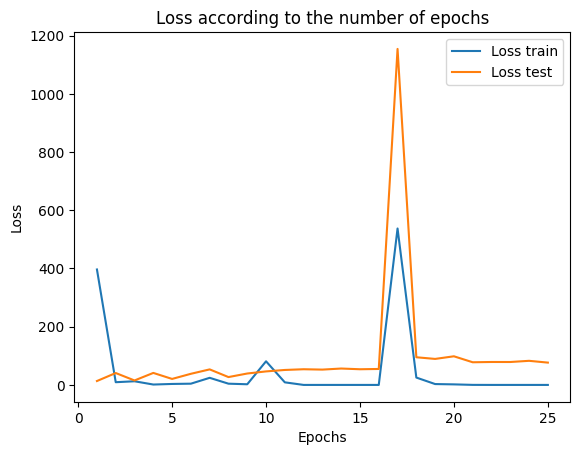

/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_1048/593280641.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(1,len(loss_train)+1), np.log(loss_train), label='Loss train')


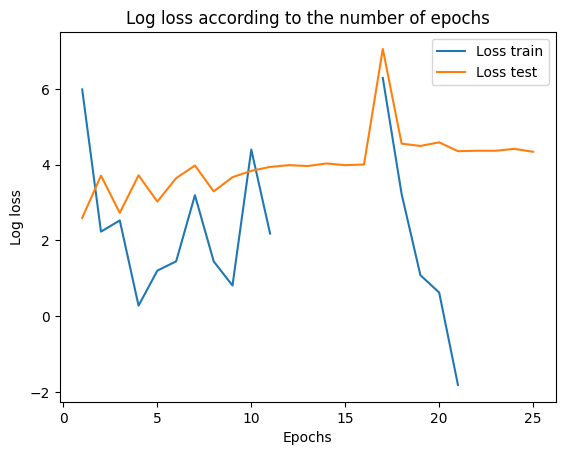

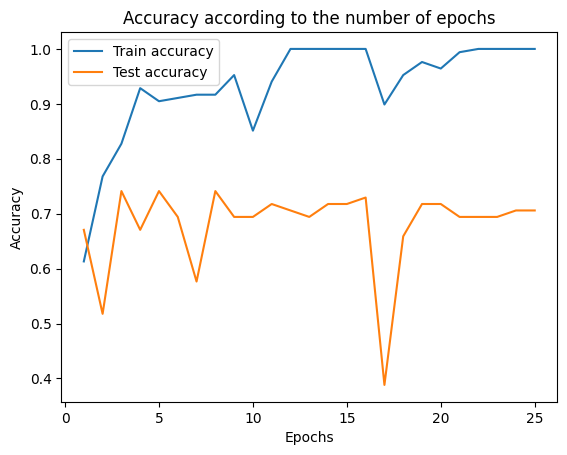

Confusion Matrix, Without Normalization


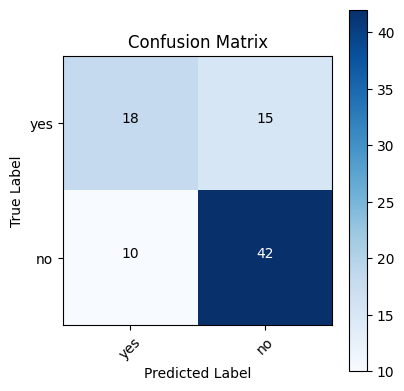

              precision    recall  f1-score   support

         yes       0.64      0.55      0.59        33
          no       0.74      0.81      0.77        52

    accuracy                           0.71        85
   macro avg       0.69      0.68      0.68        85
weighted avg       0.70      0.71      0.70        85



In [59]:
evaluation_plots(conv_class, test_loader_best, loss_train, acc_train, loss_test, acc_test)

In [60]:
results = {'Accuracy':[accuracy_score(predict(conv_class, test_loader)[0],predict(conv_class, test_loader)[1])],
           
           'Precision':[precision_score(predict(conv_class, test_loader)[0],predict(conv_class, test_loader)[1])],
           
           'Recall':[recall_score(predict(conv_class, test_loader)[0],predict(conv_class, test_loader)[1])],
           
           'F1-score':[f1_score(predict(conv_class, test_loader)[0],predict(conv_class, test_loader)[1])]}

class_results = pd.DataFrame(results, index=['Classifier wide 1'])

In [51]:
accuracy_score(predict(conv_class, test_loader)[0],predict(conv_class, test_loader)[1])

0.7411764705882353

In [61]:
class_results

,Accuracy,Precision,Recall,F1-score
Classifier wide 1,0.705882,0.736842,0.807692,0.770642


### Optimization of the wide architecture

Weights and biases project: https://wandb.ai/oriane-cavrois/brain_image_large_archi_optimization_4

In [30]:
class classifier_large_optim(nn.Module):

    def __init__(self, nb_kernel, conv_kernel_size, maxpool_kernel_size, dropout_rate):
        super(classifier_large_optim, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=nb_kernel, kernel_size=conv_kernel_size, padding=int((conv_kernel_size - 1)/2))
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_features=nb_kernel*(150 // maxpool_kernel_size)**2, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=maxpool_kernel_size, padding=0)
        x = self.dropout1(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        
        return x

In [20]:
# Define the number of folds and batch size
k_folds = 3

# Count the number of iterations
iterations = 50

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Hyperparameters distribution
epochs_distrib = [5,10,15,20,25,30,35,40]
lr_distrib = np.linspace(1e-4, 1e-2, 19)
batch_size_distrib = np.arange(3,12)
nb_kernel_distrib = [25,30,35,40,45,50,55,60,65,70,75]
conv_kernel_size_distrib = [1,3,5,7]
maxpool_kernel_size_distrib = [2,3,4,5,6,7,8]
dropout_rate_distrib = np.linspace(0, 1, 21)

params = {}
loss_train_dict = {}
acc_train_dict = {}
test_loss_dict = {}
test_acc_dict = {}

# Select randomly value from the distribution
for i in range(iterations):
    print('Iteration', i+1)
    epoch = random.choice(epochs_distrib)
    lr = random.choice(lr_distrib)
    batch_size = int(random.choice(batch_size_distrib))
    nb_kernel = random.choice(nb_kernel_distrib)
    conv_kernel_size = random.choice(conv_kernel_size_distrib)
    maxpool_kernel_size = random.choice(maxpool_kernel_size_distrib)
    dropout_rate = random.choice(dropout_rate_distrib)
    
    # Initialize the model and optimizer
    conv_class = classifier_large_optim(nb_kernel, conv_kernel_size, maxpool_kernel_size, dropout_rate)
    
    params[i] = (epoch, lr, batch_size, nb_kernel, conv_kernel_size, maxpool_kernel_size, dropout_rate)
    
    loss_fn = nn.NLLLoss()
    learning_rate = lr
    optimizer_cl = torch.optim.RMSprop(conv_class.parameters())
    
    loss_train_iter = []
    acc_train_iter = []
    test_loss_iter = []
    test_acc_iter = []
    print('Number of epochs:',epoch)
    print(params[i])
    
    run = wandb.init(
        # Set the project where this run will be logged
        project="brain_image_large_archi_optimization_4",
        # Track hyperparameters and run metadata
        config={"epochs": epoch, "learning_rate": lr, "batch size": batch_size, "kernel number":nb_kernel, 
                "conv kernel size":conv_kernel_size, "maxpool kernel size":maxpool_kernel_size, "drop out": dropout_rate}
    )
    with run:
        # Loop through each fold
        for fold, (train_idx, test_idx) in enumerate(kf.split(dsets['train'])):
            print(f"Fold {fold + 1}")
            print("-------")

            # Define the data loaders for the current fold
            train_loader_cv = torch.utils.data.DataLoader(
                dataset=dsets['train'],
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(train_idx),
            )
            test_loader_cv = torch.utils.data.DataLoader(
                dataset=dsets['train'],
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(test_idx),
            )

            # Train the model on the current fold
            loss_train, acc_train = train(conv_class, train_loader_cv, loss_fn, optimizer_cl, epoch, verbose=False)

            loss_train_iter.append(loss_train)
            acc_train_iter.append(acc_train)
            # Evaluate the model on the test set
            conv_class.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader_cv:
                    data, target = data.to(device), target.to(device)
                    output = conv_class(data)
                    test_loss += nn.functional.nll_loss(output, target, reduction="sum").item()
                    pred = output.max(1, keepdim=True)[1]
                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_loss_iter.append(test_loss)
            accuracy = 100.0 * correct / len(test_loader.dataset)
            test_acc_iter.append(correct / len(test_loader.dataset))

            # Print the results for the current fold
            print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
            
        loss_train_dict[i] = np.mean(loss_train_iter)
        acc_train_dict[i] = np.mean(acc_train_iter)
        test_loss_dict[i] = np.mean(test_loss_iter)
        test_acc_dict[i] = np.mean(test_acc_iter)
        
        wandb.log({"train accuracy": acc_train_dict[i], "train loss": loss_train_dict[i], "test accuracy": test_acc_dict[i], "test loss": test_loss_dict[i]})
        
        print("--------------------------------------")

Iteration 1
Number of epochs: 30
(30, 0.0089, 9, 25, 7, 6, 0.4)


Fold 1
-------
Test set: Average loss: 19.5985, Accuracy: 41/85 (48.24%)

Fold 2
-------
Test set: Average loss: 10.2880, Accuracy: 43/85 (50.59%)

Fold 3
-------
Test set: Average loss: 4.2216, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.53725
test loss,11.36937
train accuracy,0.92937
train loss,2.44413


Iteration 2
Number of epochs: 30
(30, 0.00835, 3, 65, 3, 7, 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 7.4222, Accuracy: 50/85 (58.82%)

Fold 2
-------
Test set: Average loss: 2.9559, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 3.3635, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.61569
test loss,4.58055
train accuracy,0.86786
train loss,4.4881


Iteration 3
Number of epochs: 35
(35, 0.00725, 8, 30, 7, 2, 0.9)


Fold 1
-------
Test set: Average loss: 155.5494, Accuracy: 42/85 (49.41%)

Fold 2
-------
Test set: Average loss: 14.5188, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 14.6825, Accuracy: 55/85 (64.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58824
test loss,61.58354
train accuracy,0.92577
train loss,11.56011


Iteration 4
Number of epochs: 10
(10, 0.0089, 4, 35, 5, 4, 0.65)


Fold 1
-------
Test set: Average loss: 20.0765, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 169.7820, Accuracy: 16/85 (18.82%)

Fold 3
-------
Test set: Average loss: 12.2055, Accuracy: 51/85 (60.00%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.43529
test loss,67.3547
train accuracy,0.87708
train loss,7.97641


Iteration 5
Number of epochs: 5
(5, 0.006150000000000001, 11, 55, 7, 8, 0.2)


Fold 1
-------
Test set: Average loss: 59.6505, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 10.1883, Accuracy: 46/85 (54.12%)

Fold 3
-------
Test set: Average loss: 1.0051, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.55686
test loss,23.61464
train accuracy,0.79226
train loss,12.62931


Iteration 6
Number of epochs: 35
(35, 0.005600000000000001, 8, 50, 1, 3, 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 9.9037, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 9.1785, Accuracy: 48/85 (56.47%)

Fold 3
-------
Test set: Average loss: 0.0444, Accuracy: 55/85 (64.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58039
test loss,6.37554
train accuracy,0.93325
train loss,0.64231


Iteration 7
Number of epochs: 15
(15, 0.00945, 11, 55, 5, 5, 0.2)


Fold 1
-------
Test set: Average loss: 9.2984, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 1.3083, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 0.0557, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59216
test loss,3.55413
train accuracy,0.9123
train loss,5.22964


Iteration 8
Number of epochs: 5
(5, 0.00285, 11, 45, 7, 7, 1.0)


Fold 1
-------
Test set: Average loss: 0.4620, Accuracy: 32/85 (37.65%)

Fold 2
-------
Test set: Average loss: 0.4203, Accuracy: 39/85 (45.88%)

Fold 3
-------
Test set: Average loss: 0.4516, Accuracy: 32/85 (37.65%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.40392
test loss,0.44461
train accuracy,0.6131
train loss,0.06589


Iteration 9
Number of epochs: 5
(5, 0.0045000000000000005, 4, 60, 5, 6, 0.6000000000000001)


Fold 1
-------
Test set: Average loss: 12.5106, Accuracy: 48/85 (56.47%)

Fold 2
-------
Test set: Average loss: 4.2650, Accuracy: 47/85 (55.29%)

Fold 3
-------
Test set: Average loss: 4.4821, Accuracy: 48/85 (56.47%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56078
test loss,7.08591
train accuracy,0.79821
train loss,12.32058


Iteration 10
Number of epochs: 5
(5, 0.0023, 5, 55, 5, 4, 0.65)


Fold 1
-------
Test set: Average loss: 17.2838, Accuracy: 40/85 (47.06%)

Fold 2
-------
Test set: Average loss: 43.8983, Accuracy: 40/85 (47.06%)

Fold 3
-------
Test set: Average loss: 1.2567, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.52157
test loss,20.81296
train accuracy,0.82024
train loss,13.94929


Iteration 11
Number of epochs: 10
(10, 0.0045000000000000005, 11, 55, 3, 4, 0.9)


Fold 1
-------
Test set: Average loss: 6.6628, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 1.0136, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 24.6524, Accuracy: 41/85 (48.24%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.53725
test loss,10.77628
train accuracy,0.77946
train loss,2.77912


Iteration 12
Number of epochs: 40
(40, 0.00395, 4, 60, 7, 5, 0.75)


Fold 1
-------
Test set: Average loss: 83.6354, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 59.5535, Accuracy: 51/85 (60.00%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58824
test loss,47.72965
train accuracy,0.94464
train loss,7.78004


Iteration 13
Number of epochs: 5
(5, 0.0001, 7, 30, 5, 3, 0.2)


Fold 1
-------
Test set: Average loss: 19.4904, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 5.6745, Accuracy: 46/85 (54.12%)

Fold 3
-------
Test set: Average loss: 0.6141, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56078
test loss,8.593
train accuracy,0.83333
train loss,29.39837


Iteration 14
Number of epochs: 25
(25, 0.005050000000000001, 5, 75, 5, 4, 0.65)


Fold 1
-------
Test set: Average loss: 77.7994, Accuracy: 38/85 (44.71%)

Fold 2
-------
Test set: Average loss: 13.6244, Accuracy: 52/85 (61.18%)

Fold 3
-------
Test set: Average loss: 29.3711, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56078
test loss,40.265
train accuracy,0.94202
train loss,8.53346


Iteration 15
Number of epochs: 15
(15, 0.006150000000000001, 10, 75, 1, 6, 0.9500000000000001)


Fold 1
-------
Test set: Average loss: 8.2841, Accuracy: 29/85 (34.12%)

Fold 2
-------
Test set: Average loss: 1.1861, Accuracy: 47/85 (55.29%)

Fold 3
-------
Test set: Average loss: 0.2524, Accuracy: 51/85 (60.00%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.49804
test loss,3.24087
train accuracy,0.74048
train loss,0.97077


Iteration 16
Number of epochs: 40
(40, 0.00395, 3, 40, 5, 3, 1.0)


Fold 1
-------
Test set: Average loss: 0.4274, Accuracy: 36/85 (42.35%)

Fold 2
-------
Test set: Average loss: 0.4311, Accuracy: 36/85 (42.35%)

Fold 3
-------
Test set: Average loss: 0.4737, Accuracy: 31/85 (36.47%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.40392
test loss,0.44404
train accuracy,0.61302
train loss,0.22684


Iteration 17
Number of epochs: 30
(30, 0.005050000000000001, 8, 35, 3, 3, 0.2)


Fold 1
-------
Test set: Average loss: 13.3553, Accuracy: 46/85 (54.12%)

Fold 2
-------
Test set: Average loss: 1.1402, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 0.6701, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.60392
test loss,5.05519
train accuracy,0.95883
train loss,2.73221


Iteration 18
Number of epochs: 40
(40, 0.01, 6, 55, 1, 7, 0.15000000000000002)


Fold 1
-------
Test set: Average loss: 3.9927, Accuracy: 39/85 (45.88%)

Fold 2
-------
Test set: Average loss: 0.2333, Accuracy: 52/85 (61.18%)

Fold 3
-------
Test set: Average loss: 0.8452, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56471
test loss,1.69041
train accuracy,0.96719
train loss,0.27409


Iteration 19
Number of epochs: 35
(35, 0.0045000000000000005, 3, 40, 7, 3, 0.35000000000000003)


Fold 1
-------
Test set: Average loss: 135.4227, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 41.4038, Accuracy: 52/85 (61.18%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59608
test loss,58.94219
train accuracy,0.96726
train loss,24.08918


Iteration 20
Number of epochs: 35
(35, 0.005600000000000001, 5, 50, 5, 4, 0.35000000000000003)


Fold 1
-------
Test set: Average loss: 9.1630, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 12.7770, Accuracy: 49/85 (57.65%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58431
test loss,7.31331
train accuracy,0.96029
train loss,8.00826


Iteration 21
Number of epochs: 5
(5, 0.0089, 11, 70, 5, 6, 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 45.2601, Accuracy: 29/85 (34.12%)

Fold 2
-------
Test set: Average loss: 8.1764, Accuracy: 48/85 (56.47%)

Fold 3
-------
Test set: Average loss: 3.7829, Accuracy: 50/85 (58.82%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.49804
test loss,19.0731
train accuracy,0.73452
train loss,8.42683


Iteration 22
Number of epochs: 35
(35, 0.005050000000000001, 6, 30, 5, 7, 0.9)


Fold 1
-------
Test set: Average loss: 11.0968, Accuracy: 48/85 (56.47%)

Fold 2
-------
Test set: Average loss: 1.1560, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 13.7227, Accuracy: 50/85 (58.82%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59216
test loss,8.6585
train accuracy,0.82577
train loss,2.99335


Iteration 23
Number of epochs: 20
(20, 0.00175, 8, 60, 5, 6, 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 46.7510, Accuracy: 42/85 (49.41%)

Fold 2
-------
Test set: Average loss: 18.9015, Accuracy: 44/85 (51.76%)

Fold 3
-------
Test set: Average loss: 5.2711, Accuracy: 52/85 (61.18%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.54118
test loss,23.6412
train accuracy,0.85967
train loss,3.18845


Iteration 24
Number of epochs: 10
(10, 0.0012000000000000001, 7, 45, 5, 2, 0.4)


Fold 1
-------
Test set: Average loss: 31.6520, Accuracy: 46/85 (54.12%)

Fold 2
-------
Test set: Average loss: 13.5676, Accuracy: 51/85 (60.00%)

Fold 3
-------
Test set: Average loss: 2.4810, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59216
test loss,15.90022
train accuracy,0.90298
train loss,49.89066


Iteration 25
Number of epochs: 10
(10, 0.00835, 10, 65, 3, 3, 0.9500000000000001)


Fold 1
-------
Test set: Average loss: 23.7646, Accuracy: 39/85 (45.88%)

Fold 2
-------
Test set: Average loss: 21.0946, Accuracy: 44/85 (51.76%)

Fold 3
-------
Test set: Average loss: 16.2201, Accuracy: 44/85 (51.76%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.49804
test loss,20.35976
train accuracy,0.71905
train loss,7.39808


Iteration 26
Number of epochs: 5
(5, 0.00835, 6, 55, 1, 7, 0.15000000000000002)


Fold 1
-------
Test set: Average loss: 4.9009, Accuracy: 36/85 (42.35%)

Fold 2
-------
Test set: Average loss: 0.0556, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 0.0325, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56078
test loss,1.66301
train accuracy,0.86488
train loss,1.08185


Iteration 27
Number of epochs: 30
(30, 0.0001, 7, 60, 1, 5, 0.55)


Fold 1
-------
Test set: Average loss: 5.5697, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 2.8815, Accuracy: 47/85 (55.29%)

Fold 3
-------
Test set: Average loss: 1.3688, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.57255
test loss,3.27335
train accuracy,0.94087
train loss,0.60792


Iteration 28
Number of epochs: 30
(30, 0.00725, 5, 30, 3, 5, 0.4)


Fold 1
-------
Test set: Average loss: 1.2257, Accuracy: 52/85 (61.18%)

Fold 2
-------
Test set: Average loss: 4.3398, Accuracy: 48/85 (56.47%)

Fold 3
-------
Test set: Average loss: 5.0157, Accuracy: 48/85 (56.47%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58039
test loss,3.52708
train accuracy,0.94583
train loss,1.73955


Iteration 29
Number of epochs: 10
(10, 0.0023, 5, 40, 1, 5, 0.1)


Fold 1
-------
Test set: Average loss: 2.2058, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 0.3082, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 0.2090, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59216
test loss,0.90766
train accuracy,0.91637
train loss,0.97703


Iteration 30
Number of epochs: 35
(35, 0.0012000000000000001, 9, 70, 7, 7, 0.75)


Fold 1
-------
Test set: Average loss: 18.9349, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 17.5478, Accuracy: 52/85 (61.18%)

Fold 3
-------
Test set: Average loss: 1.6336, Accuracy: 55/85 (64.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.59608
test loss,12.70544
train accuracy,0.91514
train loss,3.59698


Iteration 31
Number of epochs: 30
(30, 0.00395, 6, 40, 7, 3, 0.30000000000000004)


Fold 1
-------
Test set: Average loss: 34.5812, Accuracy: 49/85 (57.65%)

Fold 2
-------
Test set: Average loss: 8.5662, Accuracy: 55/85 (64.71%)

Fold 3
-------
Test set: Average loss: 21.1482, Accuracy: 55/85 (64.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.62353
test loss,21.4319
train accuracy,0.95139
train loss,20.4978


Iteration 32
Number of epochs: 15
(15, 0.0001, 6, 35, 3, 7, 1.0)


Fold 1
-------
Test set: Average loss: 0.4793, Accuracy: 18/85 (21.18%)

Fold 2
-------
Test set: Average loss: 0.4824, Accuracy: 18/85 (21.18%)

Fold 3
-------
Test set: Average loss: 0.4695, Accuracy: 26/85 (30.59%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.24314
test loss,0.47707
train accuracy,0.6127
train loss,0.11341


Iteration 33
Number of epochs: 5
(5, 0.005050000000000001, 6, 60, 1, 4, 0.2)


Fold 1
-------
Test set: Average loss: 7.0040, Accuracy: 44/85 (51.76%)

Fold 2
-------
Test set: Average loss: 1.9607, Accuracy: 51/85 (60.00%)

Fold 3
-------
Test set: Average loss: 2.3781, Accuracy: 46/85 (54.12%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.55294
test loss,3.78095
train accuracy,0.87917
train loss,3.43179


Iteration 34
Number of epochs: 30
(30, 0.006150000000000001, 9, 50, 7, 5, 0.35000000000000003)


Fold 1
-------
Test set: Average loss: 16.7469, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 5.8411, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 0.1080, Accuracy: 55/85 (64.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.6
test loss,7.56532
train accuracy,0.93938
train loss,9.92507


Iteration 35
Number of epochs: 5
(5, 0.00945, 6, 35, 3, 3, 0.0)


Fold 1
-------
Test set: Average loss: 22.5295, Accuracy: 41/85 (48.24%)

Fold 2
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.6
test loss,7.50984
train accuracy,0.89286
train loss,11.20018


Iteration 36
Number of epochs: 10
(10, 0.0045000000000000005, 4, 70, 7, 8, 0.5)


Fold 1
-------
Test set: Average loss: 15.5959, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 18.0917, Accuracy: 47/85 (55.29%)

Fold 3
-------
Test set: Average loss: 6.0696, Accuracy: 53/85 (62.35%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.56863
test loss,13.25239
train accuracy,0.86012
train loss,10.85102


Iteration 37
Number of epochs: 15
(15, 0.0078000000000000005, 8, 40, 1, 2, 0.2)


Fold 1
-------
Test set: Average loss: 21.1692, Accuracy: 46/85 (54.12%)

Fold 2
-------
Test set: Average loss: 2.5788, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 0.8080, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.60392
test loss,8.18537
train accuracy,0.94901
train loss,3.352


Iteration 38
Number of epochs: 15
(15, 0.00285, 5, 40, 7, 6, 0.25)


Fold 1
-------
Test set: Average loss: 4.6989, Accuracy: 49/85 (57.65%)

Fold 2
-------
Test set: Average loss: 12.4599, Accuracy: 49/85 (57.65%)

Fold 3
-------
Test set: Average loss: 573.9117, Accuracy: 27/85 (31.76%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.4902
test loss,197.0235
train accuracy,0.9246
train loss,6.51065


Iteration 39
Number of epochs: 20
(20, 0.00175, 8, 45, 1, 2, 0.65)


Fold 1
-------
Test set: Average loss: 10.1113, Accuracy: 43/85 (50.59%)

Fold 2
-------
Test set: Average loss: 2.1230, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 5.4965, Accuracy: 52/85 (61.18%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58039
test loss,5.91026
train accuracy,0.93705
train loss,2.82581


Iteration 40
Number of epochs: 25
(25, 0.00395, 4, 50, 7, 6, 0.05)


Fold 1
-------
Test set: Average loss: 23.8693, Accuracy: 46/85 (54.12%)

Fold 2
-------
Test set: Average loss: 2561.0636, Accuracy: 21/85 (24.71%)

Fold 3
-------
Test set: Average loss: 4.0079, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.47451
test loss,862.98027
train accuracy,0.96405
train loss,7.99005


Iteration 41
Number of epochs: 40
(40, 0.006150000000000001, 7, 45, 5, 6, 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 24.7171, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 9.5840, Accuracy: 52/85 (61.18%)

Fold 3
-------
Test set: Average loss: 4.8217, Accuracy: 52/85 (61.18%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.58431
test loss,13.04093
train accuracy,0.90722
train loss,1.98624


Iteration 42
Number of epochs: 40
(40, 0.00945, 9, 65, 5, 3, 0.1)


Fold 1
-------
Test set: Average loss: 22.3802, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 13.8571, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 0.9583, Accuracy: 55/85 (64.71%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.6
test loss,12.39855
train accuracy,0.97091
train loss,12.88571


Iteration 43
Number of epochs: 30
(30, 0.0023, 10, 50, 1, 7, 0.5)


Fold 1
-------
Test set: Average loss: 2.1676, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 0.6115, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 0.1308, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.6
test loss,0.96996
train accuracy,0.93859
train loss,0.19924


Iteration 44
Number of epochs: 35
(35, 0.0089, 3, 50, 3, 3, 0.45)


Fold 1
-------
Test set: Average loss: 20.8265, Accuracy: 48/85 (56.47%)

Fold 2
-------
Test set: Average loss: 25.7047, Accuracy: 50/85 (58.82%)

Fold 3
-------
Test set: Average loss: 0.0000, Accuracy: 56/85 (65.88%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.60392
test loss,15.5104
train accuracy,0.96412
train loss,8.88903


Iteration 45
Number of epochs: 5
(5, 0.00725, 5, 65, 1, 3, 0.8)


Fold 1
-------
Test set: Average loss: 3.1071, Accuracy: 48/85 (56.47%)

Fold 2
-------
Test set: Average loss: 16.4148, Accuracy: 33/85 (38.82%)

Fold 3
-------
Test set: Average loss: 0.5360, Accuracy: 52/85 (61.18%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.52157
test loss,6.68597
train accuracy,0.80952
train loss,4.93599


Iteration 46
Number of epochs: 30
(30, 0.0078000000000000005, 3, 70, 1, 8, 0.7000000000000001)


Fold 1
-------
Test set: Average loss: 4.3875, Accuracy: 46/85 (54.12%)

Fold 2
-------
Test set: Average loss: 0.8352, Accuracy: 52/85 (61.18%)

Fold 3
-------
Test set: Average loss: 3.4634, Accuracy: 49/85 (57.65%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.57647
test loss,2.89535
train accuracy,0.90833
train loss,0.70813


Iteration 47
Number of epochs: 15
(15, 0.0045000000000000005, 4, 40, 1, 2, 0.8500000000000001)


Fold 1
-------
Test set: Average loss: 17.1691, Accuracy: 40/85 (47.06%)

Fold 2
-------
Test set: Average loss: 3.4122, Accuracy: 53/85 (62.35%)

Fold 3
-------
Test set: Average loss: 3.8890, Accuracy: 47/85 (55.29%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.54902
test loss,8.15679
train accuracy,0.8879
train loss,2.39154


Iteration 48
Number of epochs: 35
(35, 0.0045000000000000005, 8, 50, 7, 6, 0.2)


Fold 1
-------
Test set: Average loss: 16.1465, Accuracy: 45/85 (52.94%)

Fold 2
-------
Test set: Average loss: 4.2793, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 0.5739, Accuracy: 54/85 (63.53%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.6
test loss,6.99991
train accuracy,0.95289
train loss,5.13776


Iteration 49
Number of epochs: 10
(10, 0.00835, 10, 25, 1, 5, 0.8)


Fold 1
-------
Test set: Average loss: 18.4947, Accuracy: 21/85 (24.71%)

Fold 2
-------
Test set: Average loss: 5.0226, Accuracy: 35/85 (41.18%)

Fold 3
-------
Test set: Average loss: 0.1532, Accuracy: 52/85 (61.18%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.42353
test loss,7.89018
train accuracy,0.81756
train loss,0.6763


Iteration 50
Number of epochs: 40
(40, 0.005050000000000001, 5, 30, 3, 4, 0.8)


Fold 1
-------
Test set: Average loss: 5.9041, Accuracy: 50/85 (58.82%)

Fold 2
-------
Test set: Average loss: 1.8077, Accuracy: 54/85 (63.53%)

Fold 3
-------
Test set: Average loss: 14.8778, Accuracy: 50/85 (58.82%)

--------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test accuracy,▁
test loss,▁
train accuracy,▁
train loss,▁
test accuracy,0.60392
test loss,7.52988
train accuracy,0.93683
train loss,1.03782


### Train the best model found

After running a random search a second time, we can found the results here: https://wandb.ai/oriane-cavrois/brain_image_large_archi_optimization_4/workspace?workspace=user-oriane-cavrois

The best model has the following parameters:
- Batch size: 6 
- Epochs: 30
- Learning rate: 0.00395
- Number of kernel: 40 
- Convolution kernel size: 7 
- Maxpool kernel size: 3
- Drop out rate: 0.3

In [62]:
class classifier_large_optim_best(nn.Module):

    def __init__(self):
        super(classifier_large_optim_best, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=7, padding=3)
        self.dropout1 = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=40*50*50, out_features=2)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=3, padding=0)
        x = self.dropout1(x)
        
        flat = nn.Flatten(1,3)
        x = flat(x)
        x = self.fc(x)
        x = F.log_softmax(x,1)
        
        return x

In [63]:
train_loader_best = torch.utils.data.DataLoader(dsets['train'], batch_size=6, shuffle=True, num_workers=2)
test_loader_best = torch.utils.data.DataLoader(dsets['test'], batch_size=6, shuffle=False, num_workers=2)

conv_class2 = classifier_large_optim_best()

loss_fn = nn.NLLLoss()
learning_rate = 0.00395
optimizer_cl = torch.optim.RMSprop(conv_class2.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(conv_class2, train_loader_best, test_loader_best, loss_fn, optimizer_cl, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 717.1242 Acc: 0.5952


  3%|▎         | 1/30 [00:25<12:17, 25.42s/it]

Test - Loss: 77.2400 Acc: 0.7176
Train - Loss: 42.2199 Acc: 0.7143


  7%|▋         | 2/30 [00:51<12:00, 25.72s/it]

Test - Loss: 72.2049 Acc: 0.7294
Train - Loss: 23.5932 Acc: 0.7262


 10%|█         | 3/30 [01:17<11:36, 25.78s/it]

Test - Loss: 16.2802 Acc: 0.6471
Train - Loss: 10.1575 Acc: 0.7440


 13%|█▎        | 4/30 [01:42<11:07, 25.67s/it]

Test - Loss: 18.7434 Acc: 0.7882
Train - Loss: 3.5314 Acc: 0.8512


 17%|█▋        | 5/30 [02:09<10:54, 26.20s/it]

Test - Loss: 14.9617 Acc: 0.7059
Train - Loss: 0.8991 Acc: 0.9643


 20%|██        | 6/30 [02:35<10:27, 26.13s/it]

Test - Loss: 12.9676 Acc: 0.7529
Train - Loss: 0.9815 Acc: 0.9643


 23%|██▎       | 7/30 [03:01<09:55, 25.88s/it]

Test - Loss: 9.1175 Acc: 0.7412
Train - Loss: 0.5167 Acc: 0.9762


 27%|██▋       | 8/30 [03:26<09:24, 25.67s/it]

Test - Loss: 24.5324 Acc: 0.6706
Train - Loss: 0.9088 Acc: 0.9286


 30%|███       | 9/30 [03:51<08:56, 25.53s/it]

Test - Loss: 11.8416 Acc: 0.7765
Train - Loss: 1.5701 Acc: 0.9167


 33%|███▎      | 10/30 [04:16<08:28, 25.44s/it]

Test - Loss: 15.0613 Acc: 0.6118
Train - Loss: 125.3180 Acc: 0.6905


 37%|███▋      | 11/30 [04:42<08:03, 25.42s/it]

Test - Loss: 47.2759 Acc: 0.7765
Train - Loss: 9.3688 Acc: 0.8750


 40%|████      | 12/30 [05:08<07:41, 25.65s/it]

Test - Loss: 23.5043 Acc: 0.7412
Train - Loss: 1.0050 Acc: 0.9643


 43%|████▎     | 13/30 [05:34<07:18, 25.82s/it]

Test - Loss: 17.6535 Acc: 0.7765
Train - Loss: 0.6897 Acc: 0.9762


 47%|████▋     | 14/30 [06:00<06:54, 25.91s/it]

Test - Loss: 20.2714 Acc: 0.7765
Train - Loss: 2.7919 Acc: 0.9226


 50%|█████     | 15/30 [06:27<06:33, 26.20s/it]

Test - Loss: 12.4410 Acc: 0.7412
Train - Loss: 0.3877 Acc: 0.9821


 53%|█████▎    | 16/30 [06:53<06:05, 26.13s/it]

Test - Loss: 23.4789 Acc: 0.7529
Train - Loss: 0.0000 Acc: 1.0000


 57%|█████▋    | 17/30 [07:20<05:42, 26.35s/it]

Test - Loss: 23.0572 Acc: 0.7647
Train - Loss: 0.0000 Acc: 1.0000


 60%|██████    | 18/30 [07:45<05:12, 26.07s/it]

Test - Loss: 21.8693 Acc: 0.7529
Train - Loss: 0.0000 Acc: 1.0000


 63%|██████▎   | 19/30 [08:11<04:44, 25.86s/it]

Test - Loss: 21.9435 Acc: 0.7647
Train - Loss: 149.8989 Acc: 0.7917


 67%|██████▋   | 20/30 [08:36<04:17, 25.71s/it]

Test - Loss: 72.2248 Acc: 0.6588
Train - Loss: 6.6172 Acc: 0.9524


 70%|███████   | 21/30 [09:02<03:50, 25.66s/it]

Test - Loss: 39.4318 Acc: 0.7882
Train - Loss: 1.9067 Acc: 0.9583


 73%|███████▎  | 22/30 [09:28<03:27, 25.92s/it]

Test - Loss: 40.6272 Acc: 0.8118
Train - Loss: 0.0000 Acc: 1.0000


 77%|███████▋  | 23/30 [09:55<03:02, 26.11s/it]

Test - Loss: 41.3229 Acc: 0.8000
Train - Loss: 0.0000 Acc: 1.0000


 80%|████████  | 24/30 [10:21<02:36, 26.16s/it]

Test - Loss: 40.4593 Acc: 0.8000
Train - Loss: 0.0920 Acc: 0.9940


 83%|████████▎ | 25/30 [10:47<02:11, 26.22s/it]

Test - Loss: 44.6311 Acc: 0.7647
Train - Loss: 1.2382 Acc: 0.9702


 87%|████████▋ | 26/30 [11:14<01:45, 26.40s/it]

Test - Loss: 37.1778 Acc: 0.8000
Train - Loss: 0.0915 Acc: 0.9940


 90%|█████████ | 27/30 [11:41<01:19, 26.53s/it]

Test - Loss: 34.5121 Acc: 0.7765
Train - Loss: 0.0264 Acc: 0.9940


 93%|█████████▎| 28/30 [12:08<00:53, 26.68s/it]

Test - Loss: 32.8704 Acc: 0.7647
Train - Loss: 5.4927 Acc: 0.9048


 97%|█████████▋| 29/30 [12:35<00:26, 26.65s/it]

Test - Loss: 100.6175 Acc: 0.6353
Train - Loss: 59.7107 Acc: 0.8571


100%|██████████| 30/30 [13:01<00:00, 26.05s/it]

Test - Loss: 45.7618 Acc: 0.7529


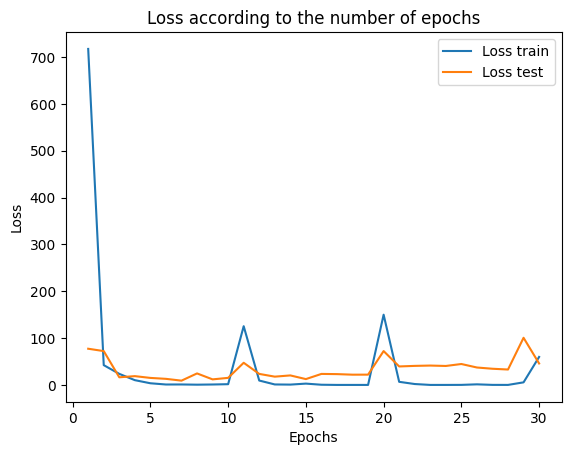

/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_1048/593280641.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(1,len(loss_train)+1), np.log(loss_train), label='Loss train')


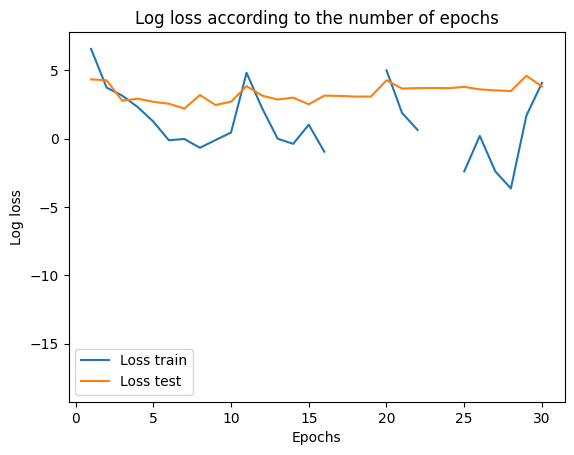

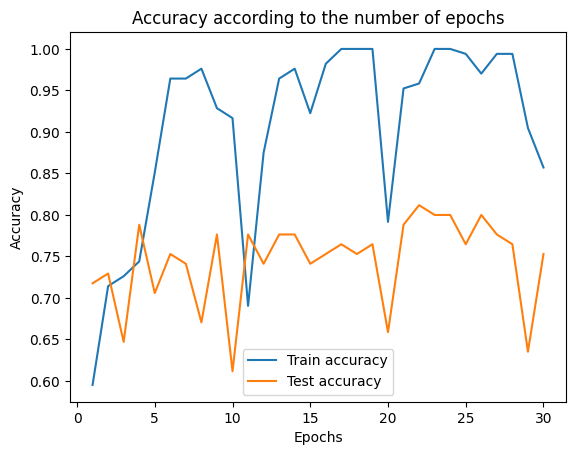

Confusion Matrix, Without Normalization


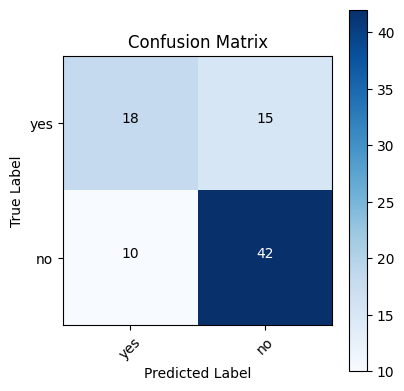

              precision    recall  f1-score   support

         yes       0.64      0.55      0.59        33
          no       0.74      0.81      0.77        52

    accuracy                           0.71        85
   macro avg       0.69      0.68      0.68        85
weighted avg       0.70      0.71      0.70        85



In [64]:
evaluation_plots(conv_class, test_loader_best, loss_train, acc_train, loss_test, acc_test)

In [65]:
results = {'Accuracy':[accuracy_score(predict(conv_class2, test_loader)[0],predict(conv_class2, test_loader)[1])],
           
           'Precision':[precision_score(predict(conv_class2, test_loader)[0],predict(conv_class2, test_loader)[1])],
           
           'Recall':[recall_score(predict(conv_class2, test_loader)[0],predict(conv_class2, test_loader)[1])],
           
           'F1-score':[f1_score(predict(conv_class2, test_loader)[0],predict(conv_class2, test_loader)[1])]}

class_results2 = pd.concat([class_results, pd.DataFrame(results, index=['Classifier wide 2 optimized'])], axis=0)

In [66]:
class_results2

,Accuracy,Precision,Recall,F1-score
Classifier wide 1,0.705882,0.736842,0.807692,0.770642
Classifier wide 2 optimized,0.752941,0.754098,0.884615,0.814159


In [67]:
print(class_results2)

                             Accuracy  Precision    Recall  F1-score
Classifier wide 1            0.705882   0.736842  0.807692  0.770642
Classifier wide 2 optimized  0.752941   0.754098  0.884615  0.814159


In [68]:
class_results2.to_csv('Results_optimized_created_models.csv')